In [ ]:
# Command to install libraries

!pip install six tensorflow matplotlib numpy cvzone scikit-learn

In [ ]:
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

2.17.1


In [ ]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):

        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):

        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

This is for the map graphical representation

In [ ]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):

    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [ ]:
import tensorflow as tf
import tarfile

class DeepLabModel:
    FROZEN_GRAPH_NAME = 'frozen_inference_graph.pb'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()

        # Use tf.compat.v1.GraphDef for TensorFlow 2.x
        graph_def = tf.compat.v1.GraphDef()

        # Extract the graph from the tarball
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def.ParseFromString(file_handle.read())
                break
        tar_file.close()

        # Import the graph into the current TensorFlow session
        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')


In [ ]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'

# Define URLs and file paths
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

# Download and load the model
import tempfile
import os
from six.moves import urllib

model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)
download_path = os.path.join(model_dir, _TARBALL_NAME)

print('Downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('Download completed! Loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('Model loaded successfully!')


Download completed! Loading DeepLab model...
Model loaded successfully!


Download completed! Loading DeepLab model...
Model loaded successfully!
Running DeepLab on the sample image...


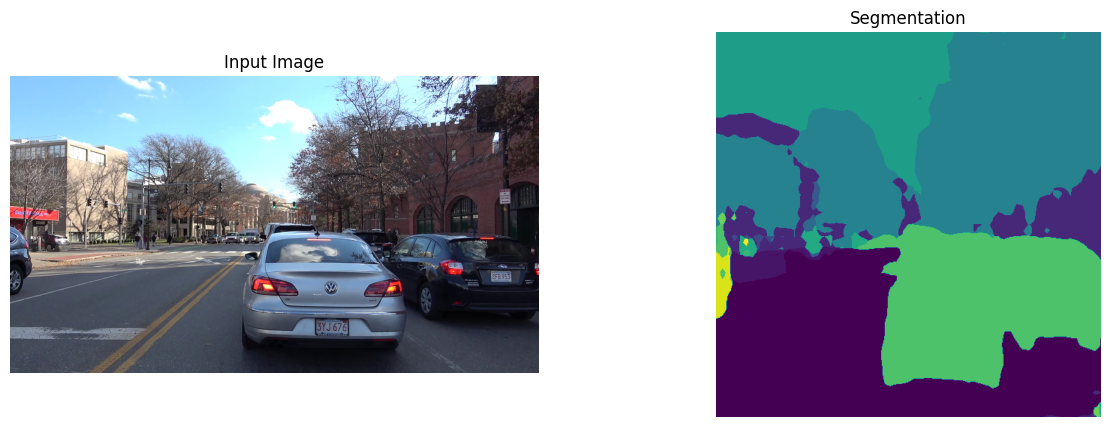

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import urllib
import tempfile
import tarfile

# Ensure that the DeepLab model is loaded (frozen_inference_graph.pb)
class DeepLabModel:
    FROZEN_GRAPH_NAME = 'frozen_inference_graph.pb'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        self.sess = tf.compat.v1.Session(graph=self.graph)

        # Load the frozen graph from the tarball
        graph_def = tf.compat.v1.GraphDef()
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def.ParseFromString(file_handle.read())
                break
        tar_file.close()

        # Import the graph into the TensorFlow session
        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        # Get input and output tensors
        self.input_tensor = self.graph.get_tensor_by_name('ImageTensor:0')
        self.output_tensor = self.graph.get_tensor_by_name('SemanticPredictions:0')

    def infer(self, image):
        """Runs inference on a single image."""
        # Resize the image to 513x513 (required input size for DeepLab)
        resized_image = image.resize((513, 513))
        input_data = np.expand_dims(np.array(resized_image), axis=0)

        # Run inference
        seg_map = self.sess.run(self.output_tensor, feed_dict={self.input_tensor: input_data})
        return seg_map[0]  # Return the segmentation map

# Visualization function to display the result
def vis_segmentation(image, seg_map):
    """Visualizes input image and segmentation map."""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')

    plt.subplot(1, 2, 2)
    plt.imshow(seg_map)
    plt.axis('off')
    plt.title('Segmentation')

    plt.show()

# Run visualization on a sample image
def run_visualization(SAMPLE_IMAGE):
    """Inferences DeepLab model and visualizes the result."""
    original_im = Image.open(SAMPLE_IMAGE)
    seg_map = MODEL.infer(original_im)  # Use the 'infer' method instead of 'run'
    vis_segmentation(original_im, seg_map)

# Download and load the model
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)
download_path = os.path.join(model_dir, _TARBALL_NAME)

# Download the model tarball
print('Downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('Download completed! Loading DeepLab model...')

# Initialize the model
MODEL = DeepLabModel(download_path)
print('Model loaded successfully!')

# Sample image URL
SAMPLE_IMAGE = 'mit_driveseg_sample.png'
if not os.path.isfile(SAMPLE_IMAGE):
    print('Downloading the sample image...')
    SAMPLE_IMAGE = urllib.request.urlretrieve('https://raw.githubusercontent.com/lexfridman/mit-deep-learning/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.png')[0]

# Run visualization
print('Running DeepLab on the sample image...')
run_visualization(SAMPLE_IMAGE)


This segmentation is not so good so we enhanced the model

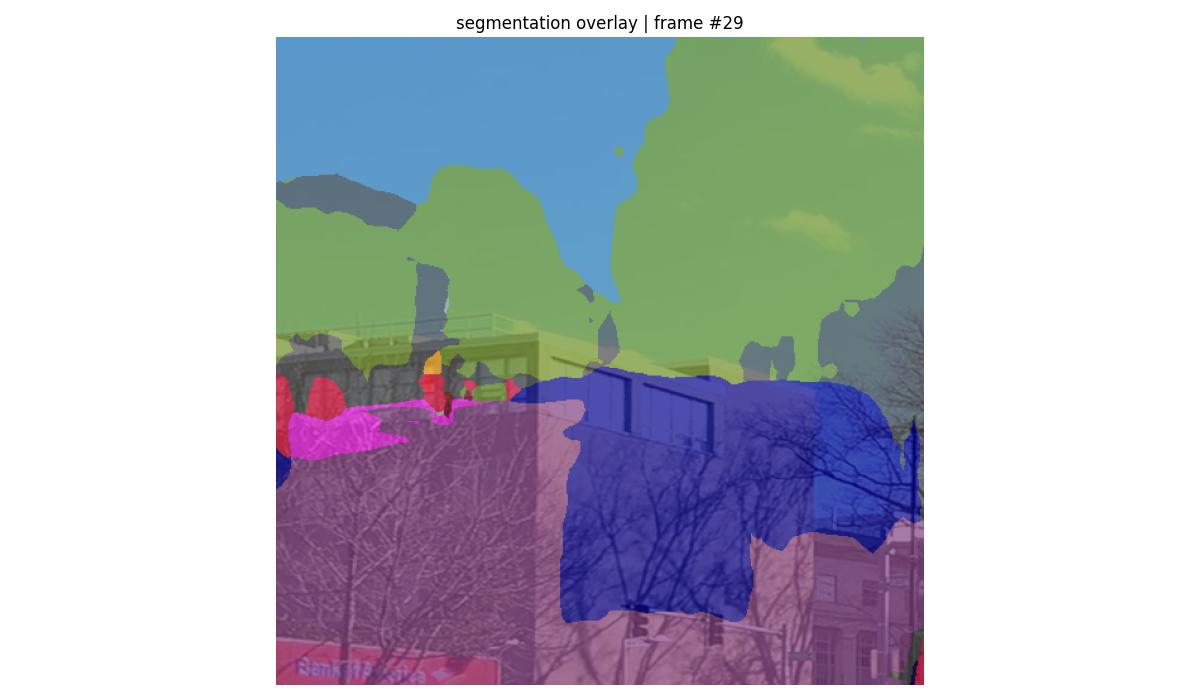

In [ ]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import IPython
import urllib

def vis_segmentation_stream(image, seg_map, index):
    """Visualizes segmentation overlay view and streams it with IPython display."""
    plt.figure(figsize=(12, 7))

    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title(f'segmentation overlay | frame #{index}')
    plt.grid(False)
    plt.tight_layout()

    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()


def run_visualization_video(frame, index):
    """Inferences DeepLab model on a video file and streams the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])  # Convert frame (BGR -> RGB)
    seg_map = MODEL.infer(original_im)  # Use infer method instead of run
    vis_segmentation_stream(original_im, seg_map, index)


# Download sample video if not available
SAMPLE_VIDEO = 'mit_driveseg_sample.mp4'
if not os.path.isfile(SAMPLE_VIDEO):
    print('Downloading the sample video...')
    SAMPLE_VIDEO = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample.mp4')[0]
print('Running DeepLab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
num_frames = 30  # Set the number of frames you want to process (e.g., 30)

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _:
            break
        run_visualization_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")


# **The above appeared image is not segmented clearly so we need to improve the model**

downloading the sample ground truth...
visualizing ground truth annotation on the sample image...


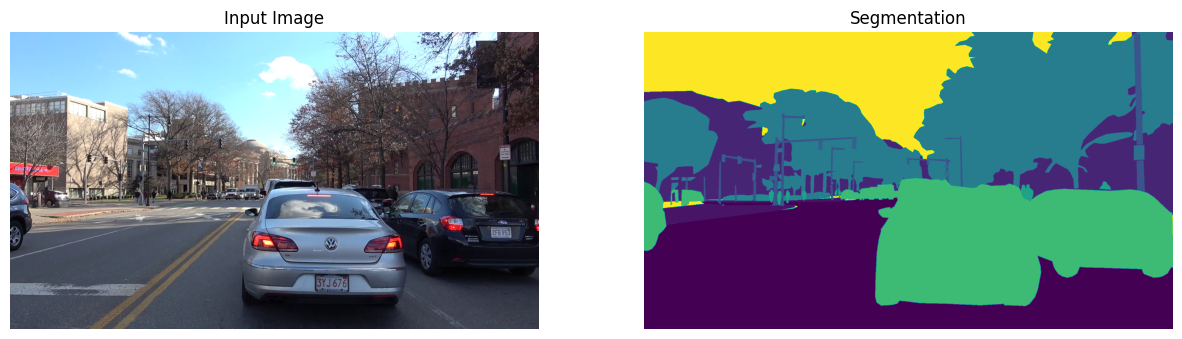

In [ ]:
class DriveSeg(object):
    """Class to load MIT DriveSeg Dataset."""

    def __init__(self, tarball_path):
        self.tar_file = tarfile.open(tarball_path)
        self.tar_info = self.tar_file.getmembers()

    def fetch(self, index):
        """Get ground truth by index.

        Args:
            index: The frame number.

        Returns:
            gt: Ground truth segmentation map.
        """
        tar_info = self.tar_info[index + 1]  # exclude index 0 which is the parent directory
        file_handle = self.tar_file.extractfile(tar_info)
        gt = np.fromstring(file_handle.read(), np.uint8)
        gt = cv.imdecode(gt, cv.IMREAD_COLOR)
        gt = gt[:, :, 0]  # select a single channel from the 3-channel image
        gt[gt==255] = 19  # void class, does not count for accuracy
        return gt


SAMPLE_GT = 'mit_driveseg_sample_gt.tar.gz'
if not os.path.isfile(SAMPLE_GT):
    print('downloading the sample ground truth...')
    SAMPLE_GT = urllib.request.urlretrieve('https://github.com/lexfridman/mit-deep-learning/raw/master/tutorial_driving_scene_segmentation/mit_driveseg_sample_gt.tar.gz')[0]

dataset = DriveSeg(SAMPLE_GT)
print('visualizing ground truth annotation on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
gt = dataset.fetch(0)  # sample image is frame 0
vis_segmentation(original_im, gt)

# **We got a quiet a good segmentation, now we need to check the accuracy of the objects detected**

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
from PIL import Image
from tabulate import tabulate

def evaluate_single(seg_map, ground_truth):
    """Evaluate a single frame with the MODEL loaded."""
    # Merge labels due to different annotation scheme
    seg_map[np.logical_or(seg_map == 14, seg_map == 15)] = 13
    seg_map[np.logical_or(seg_map == 3, seg_map == 4)] = 2
    seg_map[seg_map == 12] = 11

    # Resize segmentation map to match ground truth size
    if seg_map.shape != ground_truth.shape:
        seg_map = np.array(Image.fromarray(seg_map.astype(np.uint8)).resize(ground_truth.shape[::-1]))  # Resize (height, width)

    # Calculate accuracy on valid area
    acc = np.sum(seg_map[ground_truth != 19] == ground_truth[ground_truth != 19]) / np.sum(ground_truth != 19)

    # Select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth != 19], seg_map[ground_truth != 19],
                          labels=np.array([0, 1, 2, 5, 6, 7, 8, 9, 11, 13]))
    intersection = np.diag(cm)
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)

    return acc, intersection, union

print('Evaluating on the sample image...')

# Assuming SAMPLE_IMAGE is the correct image path
original_im = Image.open(SAMPLE_IMAGE)

# Using the correct method: infer instead of run
seg_map = MODEL.infer(original_im)

# Assuming the 'dataset.fetch()' method retrieves the ground truth
gt = dataset.fetch(0)  # Sample image is frame 0

# Evaluate the segmentation
acc, intersection, union = evaluate_single(seg_map, gt)

# Calculate and print the mean class IoU
class_iou = np.round(intersection / union, 5)
print('Pixel accuracy: %.5f' % acc)
print('Mean class IoU:', np.mean(class_iou))
print('Class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0, 1, 2, 5, 6, 7, 8, 9, 11, 13]]))


Evaluating on the sample image...
Pixel accuracy: 0.86808
Mean class IoU: 0.383802
Class IoU:
   road    sidewalk    building     pole    traffic light    traffic sign    vegetation    terrain    person     car
-------  ----------  ----------  -------  ---------------  --------------  ------------  ---------  --------  ------
0.95363     0.52201     0.42465  0.02991          0.05897          0.0027       0.78936    0.00855   0.11604  0.9322


# **The accuracy is seems to be good we can check for another sample image **

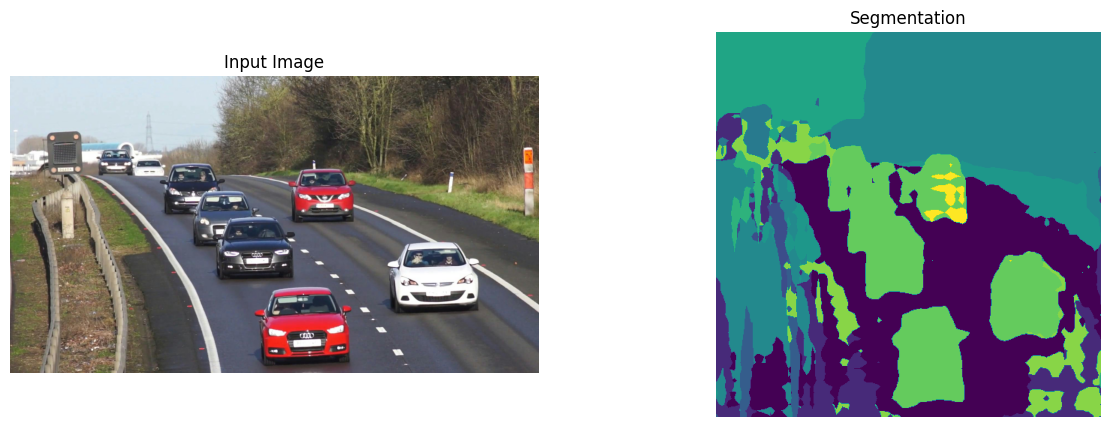

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to visualize segmentation
def vis_segmentation(image, seg_map):
    """Visualizes input image and segmentation map."""
    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')

    # Display segmentation map
    plt.subplot(1, 2, 2)
    plt.imshow(seg_map)
    plt.axis('off')
    plt.title('Segmentation')

    plt.show()

# Function to process the sample image
def run_sample_image_detection(sample_image_path):
    """Runs DeepLab model on a sample image and visualizes the segmentation."""
    # Open the sample image
    original_image = Image.open(sample_image_path)

    # Perform inference using the DeepLab model
    segmentation_map = MODEL.infer(original_image)

    # Visualize the segmentation result
    vis_segmentation(original_image, segmentation_map)

# Specify the path to the sample image
SAMPLE_IMAGE = '/content/car.jpg'  # Replace with your image path

# Run the detection
run_sample_image_detection(SAMPLE_IMAGE)


# **From the abve image we can conclude that the model is performing well**